In [15]:
!python -m pip install -q lightning --no-cache-dir
!pip install -q grad-cam
!pip install -q global_land_mask

Proceed (Y/n)? 

In [16]:
# download the metadata for all images, 50000 train images, 50000 test images
from huggingface_hub import snapshot_download
snapshot_download(repo_id="osv5m/osv5m", local_dir="datasets/osv5m", allow_patterns=[
    'images/train/00.zip',
    # 'images/train/01.zip',
    'images/test/00.zip',
    # 'images/test/01.zip',
    '*.csv'
    ], repo_type='dataset')

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

'/content/datasets/osv5m'

In [ ]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [17]:
from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

from tqdm.notebook import trange, tqdm
from time import sleep
import csv
import numpy as np

In [18]:
import os
import zipfile
for root, dirs, files in os.walk("datasets/osv5m"):
    for file in files:
        if file.endswith(".zip"):
            with zipfile.ZipFile(os.path.join(root, file), 'r') as zip_ref:
                for member in tqdm(zip_ref.infolist(), desc=f'Extracting {file}'):
                  zip_ref.extract(member, root)
            os.remove(os.path.join(root, file))

Extracting :   0%|          | 0/50001 [00:00<?, ?it/s]

Extracting :   0%|          | 0/50001 [00:00<?, ?it/s]

In [19]:
# Blocks below contain some code generated with deepseek R1 with the following prompt:
# "write a pytorch model in jupyter format to classify outdoor images by their latitude and longitude"

# Step 2: Define the custom dataset

MAX_FILES = 10000
from global_land_mask import globe
import os.path
from pathlib import Path

class ImageCoordinateDataset(Dataset):
    def __init__(self, csv_file, image_dirs, train: bool, transform=None):
        self.data = []
        self.skipped = []
        self.files = []
        for image_dir in image_dirs:
          self.files.extend([f"{image_dir}/{f}" for f in listdir(image_dir) if isfile(join(image_dir, f))])
        self.csv = 'datasets/osv5m/train.csv' if train else 'datasets/osv5m/test.csv'

        print('Reading', self.csv)
        df = pd.read_csv(self.csv, usecols=range(3))
        row_count, column_count = df.shape
        print('Filtering files...')
        print(self.files[:5])
        print(df[:5])


        # for full_path in tqdm(self.files, total=len(self.files), desc='Processing files'):
        for full_path in tqdm(self.files[:MAX_FILES], total=MAX_FILES, desc='Processing files'):
            image_name = str(Path(full_path).stem)

            row = df[df['id'] == int(image_name)].iloc[0]

            lat = row['latitude']
            lon = row['longitude']

            # Remove mislaballed images (ocean pictures?)
            if not globe.is_land(float(lat), float(lon)):
              self.skipped.append(image_name)
              continue
            self.data.append(np.array([str(full_path), float(lat), float(lon)]))

        self.transform = transform
        print(f'Dataset ready, {len(self.data)} files.')
        print(f'Skipped {len(self.skipped)} non-land files.')


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx][0]
        image = Image.open(img_path).convert('RGB')
        coordinates = (float(self.data[idx][1]), float(self.data[idx][2]))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(coordinates, dtype=torch.float32)


In [20]:
# https://github.com/gastruc/osv5m/blob/main/models/losses.py
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, x, y):
        """
        Args:
            x: torch.Tensor Bx2
            y: torch.Tensor Bx2
        Returns:
            torch.Tensor: Haversine loss between x and y: torch.Tensor([B])
        Note:
            Haversine distance doesn't contain the 2 * 6371 constant.
        """
        lhs = torch.sin((x[:, 0] - y[:, 0]) / 2) ** 2
        rhs = (
            torch.cos(x[:, 0])
            * torch.cos(y[:, 0])
            * torch.sin((x[:, 1] - y[:, 1]) / 2) ** 2
        )
        a = lhs + rhs
        return torch.arctan2(torch.sqrt(a), torch.sqrt(1 - a))

haversineLoss = HaversineLoss()

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
train_dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/train.csv', image_dirs=[
                                      '/content/datasets/osv5m/images/train/00',
                                      # '/content/datasets/osv5m/images/train/01'
                                      ],\
                                 train=True,
                                 transform=transform)

test_dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/test.csv', \
                                 image_dirs=['/content/datasets/osv5m/images/test/00', \
                                            #  '/content/datasets/osv5m/images/test/01'
                                             ], \
                                 train=False,
                                 transform=transform)

train_loader = DataLoader(
   train_dataset, batch_size=32, shuffle=True, num_workers=2
)
test_loader = DataLoader(
   test_dataset, batch_size=32, shuffle=False, num_workers=2
)

Reading datasets/osv5m/train.csv
Filtering files...
['/content/datasets/osv5m/images/train/00/518522309558106.jpg', '/content/datasets/osv5m/images/train/00/2891087094440649.jpg', '/content/datasets/osv5m/images/train/00/622385888695592.jpg', '/content/datasets/osv5m/images/train/00/1622150827972164.jpg', '/content/datasets/osv5m/images/train/00/215625393452431.jpg']
                 id   latitude   longitude
0  3859149887465501 -43.804769 -176.614093
1   574181207305439 -43.796611 -176.660483
2   333574322129026 -43.818092 -176.578383
3   636305258168031 -44.052910 -176.633065
4   166741299029322 -43.748077 -176.329626


Processing files:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset ready, 9896 files.
Skipped 104 non-land files.
Reading datasets/osv5m/test.csv
Filtering files...
['/content/datasets/osv5m/images/test/00/297514371917967.jpg', '/content/datasets/osv5m/images/test/00/803112880347376.jpg', '/content/datasets/osv5m/images/test/00/545505573348827.jpg', '/content/datasets/osv5m/images/test/00/460478585042654.jpg', '/content/datasets/osv5m/images/test/00/237289798172420.jpg']
                 id   latitude  longitude
0   547473234108938 -16.336027  45.628280
1   826109781317024  50.855687  56.147997
2  1006398440000844  37.956651  14.954485
3  2943891539215481  12.373333  -8.909906
4   122945119799579   7.510295  99.061884


Processing files:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset ready, 9873 files.
Skipped 127 non-land files.


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers.tensorboard import TensorBoardLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# used code from: https://www.datacamp.com/tutorial/pytorch-lightning-tutorial
# and https://colab.research.google.com/github/hktxt/backyard/blob/master/Lightning_demo.ipynb#scrollTo=x-34xKCI40yW
import torchvision.models as models

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('using cuda')
else:
  device = torch.device("cpu")
  print('using cpu')

class GeoLocationModel(L.LightningModule):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
      self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
      self.fc1 = nn.Linear(64 * 28 * 28, 512)
      self.fc2 = nn.Linear(512, 256)
      self.fc3 = nn.Linear(256, 2)
    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x
    def training_step(self, batch, batch_idx):
      x, y = batch
      y_hat = self(x)
      loss = haversineLoss(y_hat, y).mean(dim=-1)
      # Log the loss at each training step and epoch, create a progress bar
      self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
      return loss

    def validation_step(self, batch, batch_idx):
      x, y = batch
      y_hat = self(x)
      loss = haversineLoss(y_hat, y).mean(dim=-1)
      acc = (y_hat == y).float().mean()
      self.log('val_loss', loss)
      self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
      x, y = batch
      y_hat = self(x)
      loss = haversineLoss(y_hat, y).mean(dim=-1)
      acc = (y_hat == y).float().mean()
      self.log('test_loss', loss)
      self.log('test_acc', acc)

    def test_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs}

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5
      )

      return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "monitor": "val_loss",
        },
      }

# model = GeoLocationModel().to(device)
# print(model)

using cuda


In [24]:
checkpoint_callback = ModelCheckpoint(
   dirpath="checkpoints",
   monitor="val_loss",
   filename="GeoLocationModel-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}",
   save_top_k=3,
   mode="min",
)

In [46]:
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

In [47]:

model = GeoLocationModel()

logger = TensorBoardLogger("tb_logs", name="my_model")

trainer = L.Trainer(
   max_epochs=3,
  #  callbacks=[checkpoint_callback, early_stopping],
   accelerator="gpu" if torch.cuda.is_available() else "cpu",
   devices="auto",
   logger=logger
)

trainer.fit(model, train_loader, test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 448    | train
1 | conv2 | Conv2d    | 4.6 K  | train
2 | conv3 | Conv2d    | 18.5 K | train
3 | pool  | MaxPool2d | 0      | train
4 | fc1   | Linear    | 25.7 M | train
5 | fc2   | Linear    | 131 K  | train
6 | fc3   | Linear    | 514    | train
--------------------------------------------
25.8 M    Trainable params
0         Non-trainable params
25.8 M    Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [72]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir lightning_logs/ (started 0:04:46 ago; pid 23850)


In [76]:
!kill 23850

/bin/bash: line 1: kill: (23850) - No such process


In [75]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 23850), started 0:05:04 ago. (Use '!kill 23850' to kill it.)

<IPython.core.display.Javascript object>

In [74]:
# Step 5: Visualize some predictions (optional)
import matplotlib.pyplot as plt
import random
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
haversine = HaversineLoss()
def plot_predictions(model, dataloader, num_samples=5):
    model.eval()
    model.cuda()
    with torch.no_grad():
        for images, coordinates in dataloader:
            images = images.cuda()
            outputs = model(images)
            images = images.cpu()
            outputs = outputs.cpu()
            rand_index = random.sample(range(0, len(images) - 1), min(num_samples, len(images)))
            for i in range(min(num_samples, len(images))):
                i = rand_index[i]

                pred_lat, pred_lon = outputs[i].cpu().numpy()
                true_lat, true_lon = coordinates[i].numpy()

                haver_err = haversine(
                                      torch.tensor(np.array([[pred_lon, pred_lat]]), dtype=torch.float32).deg2rad(),
                                      torch.tensor(np.array([[true_lon, true_lat]]), dtype=torch.float32).deg2rad(),
                                      )
                # Display the image
                img = images[i].permute(1, 2, 0).numpy()
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Reverse normalization
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f'Pred: ({pred_lat:.4f}, {pred_lon:.4f})\nTrue: ({true_lat:.4f}, {true_lon:.4f})\n Haversine: {haver_err}')
                plt.axis('off')

                # World map for better understanding of how bad our prediction is
                geometry = [Point(pred_lon, pred_lat), Point(true_lon, true_lat)]
                geo_df = GeoDataFrame(geometry = geometry)
                world = gpd.read_file(url)
                geo_df.plot(ax=world.plot(color="lightgrey", figsize=(10, 6)), marker='x', c=['red', 'green'], markersize=50);

                plt.show()
            break

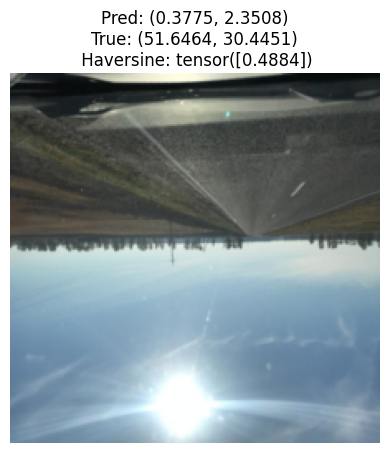

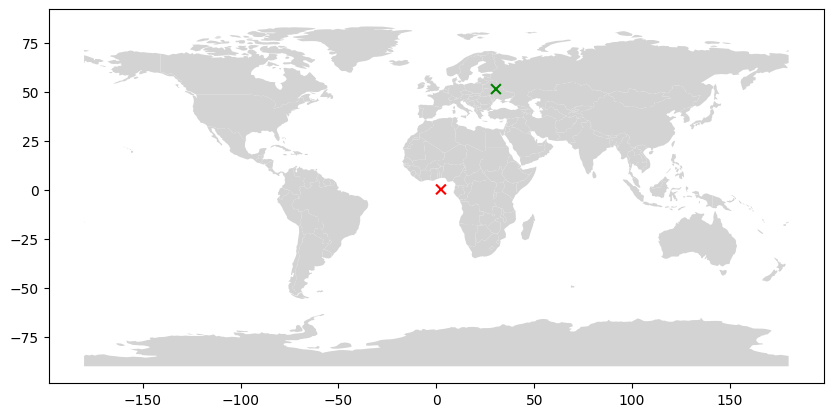

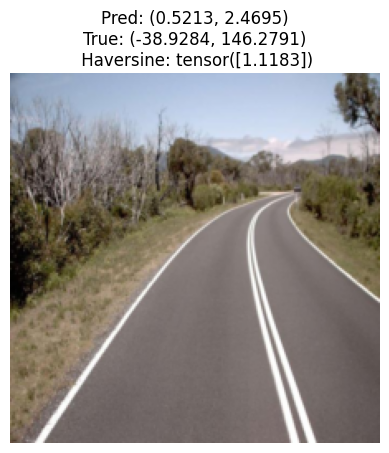

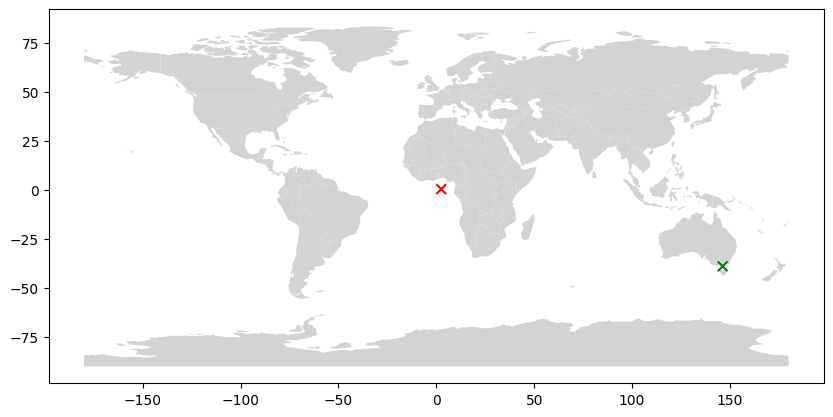

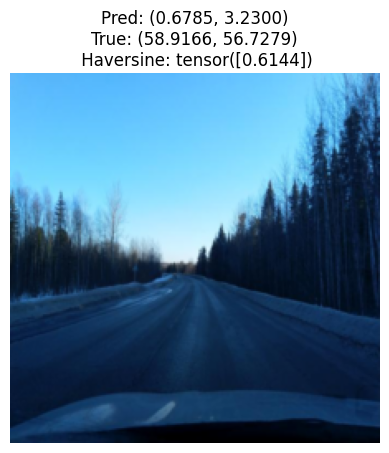

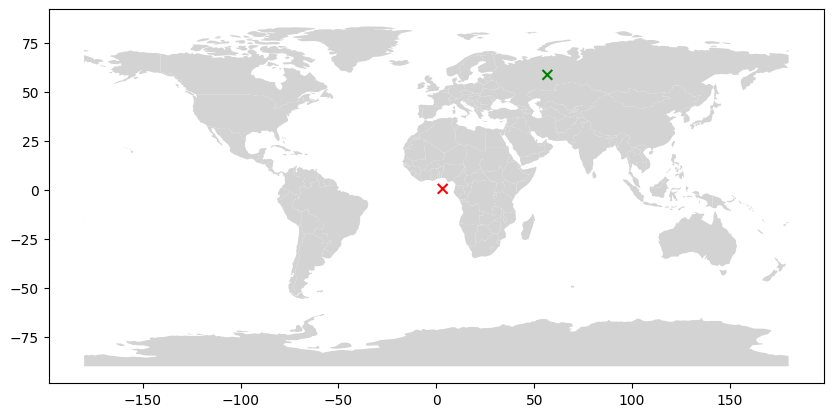

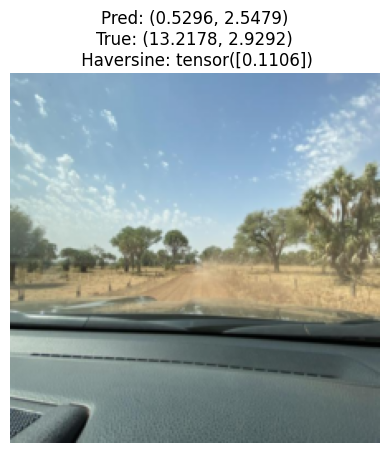

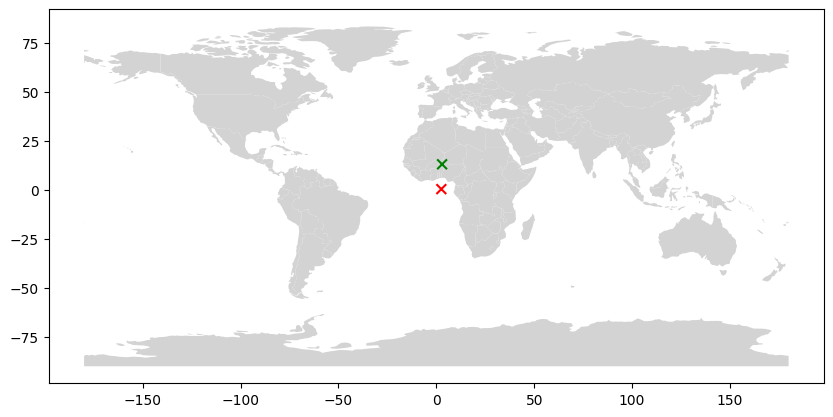

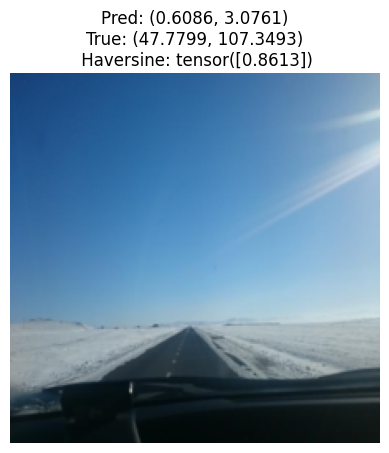

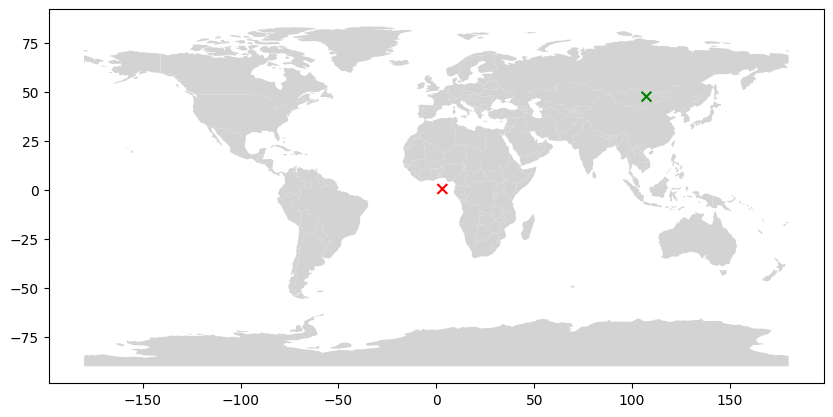

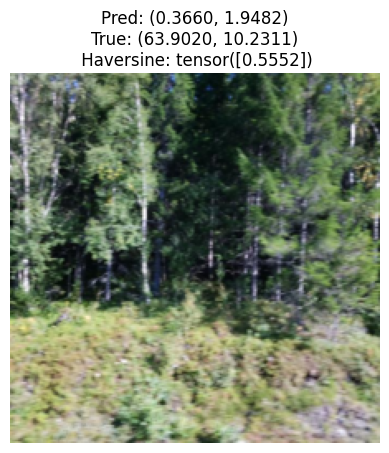

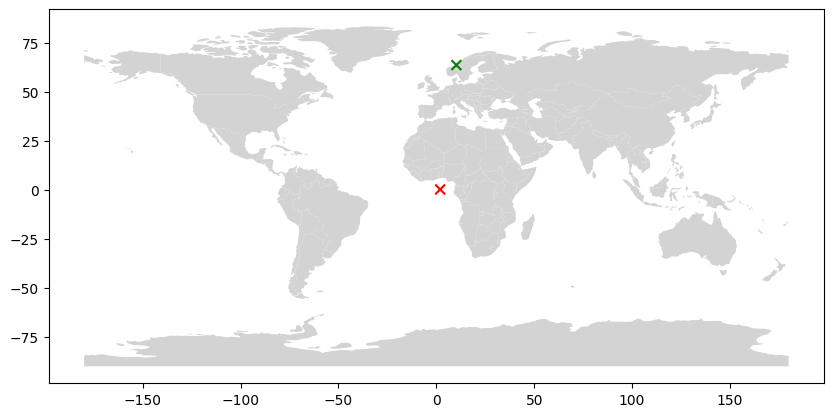

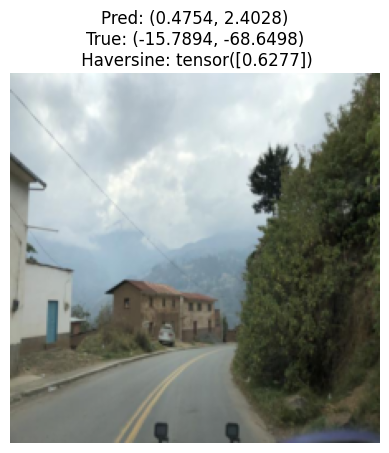

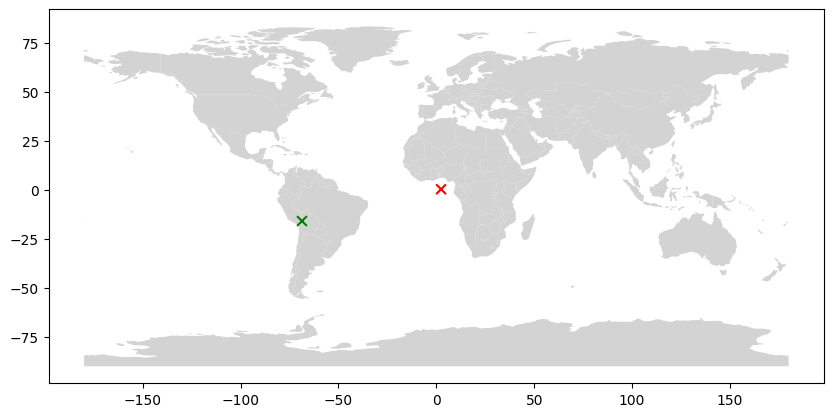

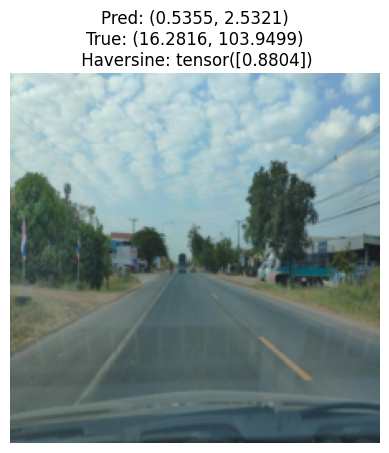

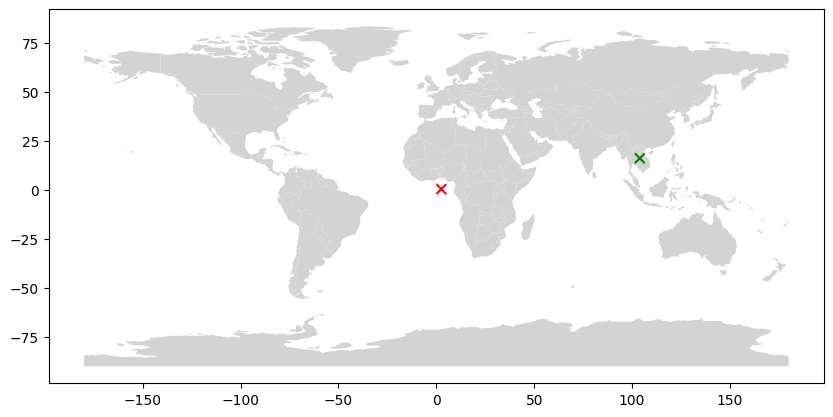

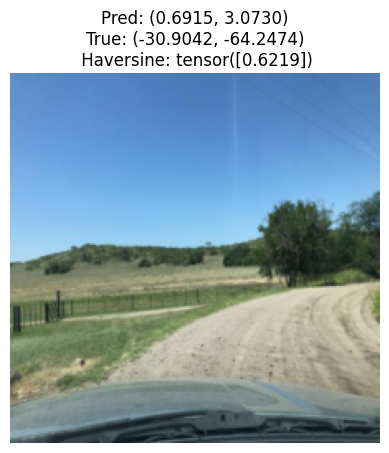

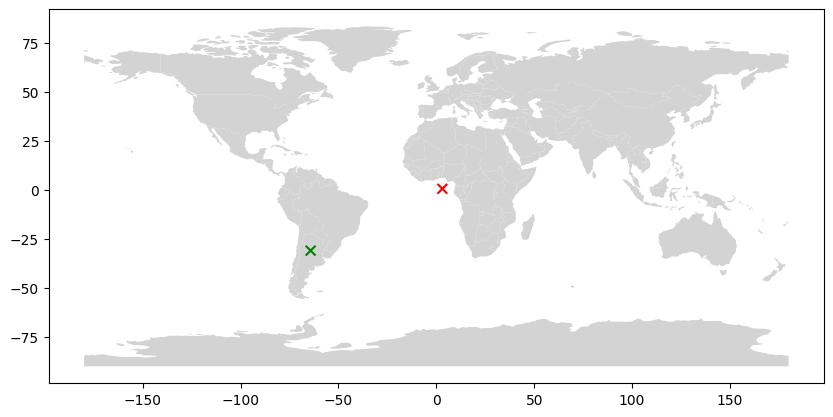

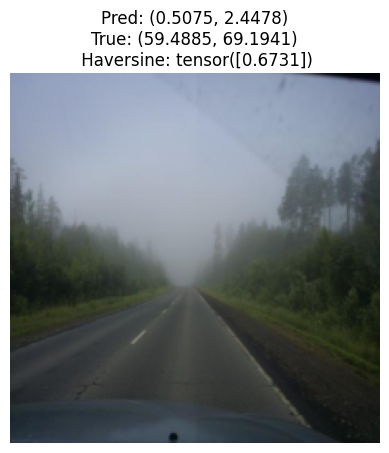

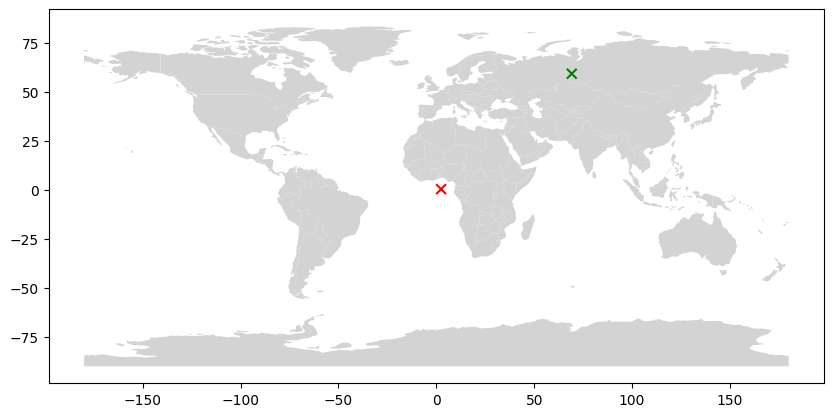

In [55]:
# Plot some predictions
plot_predictions(model, test_loader, num_samples=10)